# hpge-screening-pygeom tutorial

In [412]:
import pyg4ometry
from legendhpges import make_hpge
from l200geom import det_utils
from l200geom import vis_utils

import json
from dataclasses import dataclass
from typing import Literal
from pyg4ometry import visualisation
import argparse
import numpy as np
import logging
from pathlib import Path
from utils import visualise
from matplotlib import pyplot as plt

## Simulation of a SAGE well detector 
### More info [Boulby HPGe Screening Paper](https://arxiv.org/pdf/2308.03444)

In this example we simulate a slightly more complicated geometry, a SAGE well type detector with a aluminum holder and lead shield. This is the `lumpsey` detector with geometry from the Boubly HPGe screening paper.
When creating geometry in Geant4 it is usually a good idea to make a diagram annotating the various dimensions. Below we see an example for this geometry, annotated with the extra dimensions (mostly reasonable guesses) to make an implementation of a detector similar to this.

![Alt text](lumpsey.png)

## World volume

In [421]:
reg  = pyg4ometry.geant4.Registry()                                                                                                                                       
ws   = pyg4ometry.geant4.solid.Box("ws",400,400,400,reg)
wl   = pyg4ometry.geant4.LogicalVolume(ws,"G4_Galactic","wl",reg)
reg.setWorld(wl)


logic_list =[]
logic_names=[]

## HPGe detector
This HPGe detector is similar to a LEGEND ICPC in geometry, you can create a `metadata` block and use this to create the G4GenericPolycone representing the detector automatically.
Note that the bottom of the detector is placed at the origin and represents our reference point.

In [422]:
metadata = {
    "name": "Det",
    "type": "icpc",
    "production": {
      "enrichment": {
        "val": 0.078,
        "unc": 0.001
      }

    },
   "geometry": {
    "height_in_mm": 62,
    "radius_in_mm": 42.5,
    "borehole": {
      "radius_in_mm": 18.5,
      "depth_in_mm": 40.0
    },
    "groove": {
      "depth_in_mm": 1,
      "radius_in_mm": {
        "outer": 4,
        "inner": 3
      }
    },
    "pp_contact": {
      "radius_in_mm": 3,
      "depth_in_mm": 0
    },
    "taper": {
      "top": {
        "angle_in_deg": 30,
        "height_in_mm": 25
      },
      "bottom": {
        "angle_in_deg": 45,
        "height_in_mm": 0
      },
      "borehole": {
        "angle_in_deg": 5,
        "height_in_mm": 0
      }
    }

   }
}


In [423]:
if ('det_log' not in reg.logicalVolumeDict.keys()):
    logical_detector  = make_hpge(metadata,name="det_log",registry=reg)
    logical_detector.pygeom_color_rgba = (0, 1, 1, .9)
    physical_detector = pyg4ometry.geant4.PhysicalVolume([0,0,0],[0,0,0],logical_detector,"det_phy",wl,reg)
    physical_detector.pygeom_active_dector = det_utils.RemageDetectorInfo("germanium", "001")
    
    logic_list.append(logical_detector)




([0, 3, 3, 4, 4, 42.5, 42.5, 28.066243270259356, 18.5, 18.5, 0], [0, 0, 1, 1, 0, 0, 37, 62, 62, 22.0, 22.0])


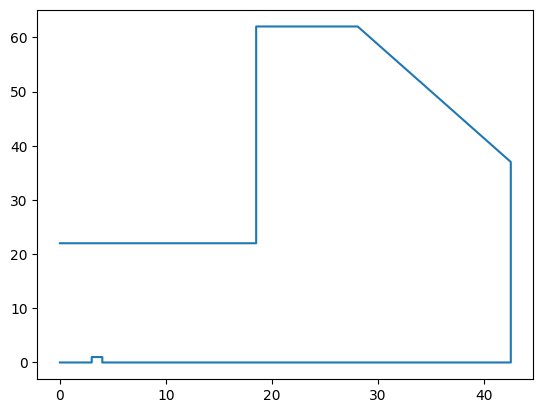

In [424]:
print(logical_detector._decode_polycone_coord())
plt.plot(*logical_detector._decode_polycone_coord())

## Outer Al shield
The outer aluminium shielding represents a bounding box for the geometry. There are several ways to create this but here we implemented the union of `solid.Tubs` for the sides and top.
Given that the origin of a `solid.Tubs` is the center care is needed to obtain the right transformation of the top relative to the sides.

In [425]:
if ("top_outer_holder_log" not in reg.logicalVolumeDict.keys()):
    outer_height= 128
    outer_thick=1.5
    outer_diameter = 113
    top_z = outer_height-58+outer_thick/2
    sides_aluminium = pyg4ometry.geant4.solid.Tubs("side_al",outer_diameter/2-outer_thick,outer_diameter/2,outer_height,0,2*np.pi,reg,"mm") #https://pyg4ometry.readthedocs.io/en/stable/autoapi/pyg4ometry/geant4/solid/Tubs/index.html
    
    top_aluminium = pyg4ometry.geant4.solid.Tubs("top_al",0,outer_diameter/2,outer_thick,0,2*np.pi,reg,"mm") #https://pyg4ometry.readthedocs.io/en/stable/autoapi/pyg4ometry/geant4/solid/Tubs/index.html
    
    logical_al_top = pyg4ometry.geant4.LogicalVolume(top_aluminium,"G4_Al","top_outer_holder_log",reg)
    logical_al_top.pygeom_color_rgba = (0.3, 0.3, 0.3, 0.1)
    logical_al_sides = pyg4ometry.geant4.LogicalVolume(sides_aluminium,"G4_Al","side_outer_holder_log",reg)
    logical_al_sides.pygeom_color_rgba = (0.7, 0.7, 0.7, 0.1)
    physical_al_top = pyg4ometry.geant4.PhysicalVolume([0,0,0],[0,0,top_z],logical_al_top,"top_outer_holder_phy",wl,reg)
    physical_al_sides = pyg4ometry.geant4.PhysicalVolume([0,0,0],[0,0,6],logical_al_sides,"sides_outer_holder_phy",wl,reg)

    logic_list.append(logical_al_top)
    logic_list.append(logical_al_sides)




## inner AL holder
This is the most challenging part of the geometry can be made easier with `solid.GenericPolycone`
A trick with this (sometimes tricky ) shape is the visualise it not rotating 2pi at first. Another trick is the plot r and z in 2D first

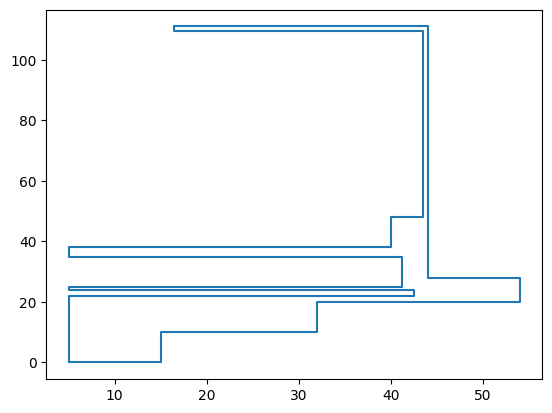

In [426]:
if ("inner_holder_log" not in reg.logicalVolumeDict.keys()):

    outer_rads=[5,15,15,32,32,54,54,44,44,16.5,16.5,43.5,43.5,40,40,5,5,41.25,41.25,5,5,42.5,42.5,5,5]
    outer_z   =[0,0,10,10,20,20,28,28,111,111,109.5,109.5,48,48,38,38,35,35,25,25,24,24,22,22,0]
    plt.plot(outer_rads,outer_z)
    plt.show()
    inner_al_inner = pyg4ometry.geant4.solid.GenericPolycone("inner_al", 0,2*np.pi, outer_rads, outer_z, reg)
    logic_al_inner=pyg4ometry.geant4.LogicalVolume(inner_al_inner,"G4_Al","inner_holder_log",reg)
    logic_al_inner.pygeom_color_rgba = (0, 0.7, 0, .3)

    physical_al_inner = pyg4ometry.geant4.PhysicalVolume([0,0,0],[0,0,-48],logic_al_inner,"inner_holder_phy",wl,reg)
    logic_list.append(logic_al_inner)

## lead shield
The lead shield is simply a disk placed below the detector

In [427]:
if ("lead_shield_log" not in reg.logicalVolumeDict.keys()):
    z_offset=-18
    inner_rad=5
    outer_rad=41.25
    height=10
    lead_shield = pyg4ometry.geant4.solid.Tubs("lead_shield",inner_rad,outer_rad,height,0,2*np.pi,reg,"mm") #https://pyg4ometry.readthedocs.io/en/stable/autoapi/pyg4ometry/geant4/solid/Tubs/index.html
    
    
    logical_lead = pyg4ometry.geant4.LogicalVolume(lead_shield,"G4_Pb","lead_shield_log",reg)
    logical_lead.pygeom_color_rgba = (1, 1, 0.1, 0.5)
    physical_lead = pyg4ometry.geant4.PhysicalVolume([0,0,0],[0,0,z_offset],logical_lead,"lead_shield_phy",wl,reg)
    logic_list.append(logical_lead)



In [ ]:
visualise(wl,logic_list)